In [1]:
!pip install --upgrade pip
!pip install tensorflow

     |████████████████████████████████| 1.5 MB 4.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |██████████████████▉             | 303.5 MB 134.2 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 516.2 MB 8.4 kB/s  eta 0:00:011     |███████████████████████████████▋| 509.4 MB 89.2 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 102.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 80.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 4.1 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 405 kB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 91 kB/s s eta 0:00:01
     |████████████████████████████████| 88 kB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 102.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 101.7 MB/s eta 0:00:01
  Created wheel for absl-py: fil

In [19]:
!pip install pyflux

     |████████████████████████████████| 1.3 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 953 kB 13.6 MB/s eta 0:00:01
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=5130318 sha256=4655ae817e2b24b62fd14d8052062178ae784383d8229b6cfc1263e73f9714c5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d0/75/75/5e6c26d910209766f8aa4bd6940e391277eb3ec2a3501f9965
Successfully built pyflux


In [37]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates

from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.vector_ar.var_model import VAR

# import pyflux as pf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import tensorflow as tf
keras = tf.keras

from datetime import datetime


---
# User-defined Functions

In [7]:
def calc_rmse(actual, pred):
    """
    Calculates the root mean squared error.
    
    Parameters
    ----------
    actual : arr
       Actural prices from a valid dataset.
    
    pred : arr
        Forecasted prices derived from one of the time series models.
    
    Returns
    -------
    
    rmse : float
        RMSE for the two provided price curves.
    """
    return np.sqrt(mean_squared_error(actual, pred))



---
# Data Import and Processing

In [27]:
def import_process_data():
    caiso = pd.read_csv('data/caiso_master.csv')
    caiso.drop('Unnamed: 0', axis=1, inplace=True)
    caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
    caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso.set_index('INTERVAL_START_PT', inplace=True)
    caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
    caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])
    return caiso

In [28]:
caiso = import_process_data()

In [10]:
caiso.reset_index(inplace=True)

In [11]:
# type(caiso['INTERVAL_START_PT'])

pandas.core.series.Series

In [29]:
np_lmp_arr = caiso['$_MWH_np15'].values
sp_lmp_arr = caiso['$_MWH_sp15'].values
zp_lmp_arr = caiso['$_MWH_zp26'].values
# Need format for ARIMA.
datetime_arr = caiso.index.to_period('H')

In [20]:
datetime_arr

0       2019-02-01 01:00:00
1       2019-02-01 02:00:00
2       2019-02-01 03:00:00
3       2019-02-01 04:00:00
4       2019-02-01 05:00:00
                ...        
11514   2020-05-30 19:00:00
11515   2020-05-30 20:00:00
11516   2020-05-30 21:00:00
11517   2020-05-30 22:00:00
11518   2020-05-30 23:00:00
Name: INTERVAL_START_PT, Length: 11519, dtype: datetime64[ns]

In [10]:
one_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-24'])
two_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-17'])
one_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-01'])
two_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-04-01'])
one_week_idx

11351

---
# ARIMA Univariate Functions

In [25]:
def arima_uni_var_train_valid_split(lmp_curve, date_rng, train_split_idx):
    """
    Splits the provided priced curve - i.e. lmp_curve - into train and validation for us in the ARIMA model.
    
    Parameters
    ----------
    lmp_curve : arr
       Historic hourly prices for either NP15, SP15 or ZP26
    
    date_rng : arr
        Values are hourly timestamps that correspond to hourly prices
    
    train_split_index : int
        The index that is used to split the univarite time series into train and validation datasets.
    
    Returns
    -------
    
    lmp_train_curve : arr
        Prices used to train ARIMA model.
    
    lmp_valid_curve : arr
        Prices used to validate ARIMA model's hourly price forecast.
    
    date_train_rng : arr
        Dates and times used to train ARIMA model.
    
    date_valid_rng : arr
        Dates used to validate ARIMA model's hourly price forecast.
    """
    
    lmp_train_curve = lmp_curve[:train_split_idx]
    lmp_valid_curve = lmp_curve[train_split_idx:]
    date_train_rng = date_rng[:train_split_idx]
    date_valid_rng = date_rng[train_split_idx:]
    return lmp_train_curve, lmp_valid_curve, date_train_rng, date_valid_rng

def arima_uni_var_fit(lmp_train, date_rng, p, d, q):
    """
    Fits a univariate ARIMA model
    
    Parameters
    ----------
    lmp_train : arr
       Prices used to train ARIMA model.
    
    date_rng : arr
        Dates and times used to train ARIMA model.
        
    p : int
        The number of lag observations included in the model, commonly referred to as the lag order.
    
    d : int
        The number of times that the raw observations are differenced, commonly referred to as the degree of differencing.
    
    q : int
        The size of the moving average window.
    
    Returns
    -------
    
    ARIMA : object
        A fitted model to be used for predicting hourly electricity prices.
    """
    
    return ARIMA(endog=lmp_train, dates=date_rng, order=(p, d, q), freq='H').fit()

def arima_uni_var_predict(model, n_period_fcst):
    """
    Fits a univariate ARIMA model
    
    Parameters
    ----------
    model : object
       A fitted ARIMA model used to forecast hourly prices.
    
    n_period_fcst : int
        Number of hours to forecast
    
    Returns
    --------
    
    Prediction: arr
        An array of forecasted electricity prices
    """
    
    return model.forecast(steps=n_period_fcst)[0]

def plot_lstm_v_arima_vs_actuals(y_true, y_lstm, y_arima, date_rng):
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(date_rng, y_lstm, 'g.-', label='LSTM', lw=2)
    ax.plot(date_rng, y_arima, 'b.-', label='ARIMA', lw=2)
    ax.plot(date_rng, y_true, 'r.', label='Actual')
    ax.set_title('Prediction vs Actual', fontsize=18, fontweight='bold')
    ax.set_xlabel('$/MWh', fontsize=12)
    ax.legend();



# Baseline Model Function

In [34]:
def baseline_fcst(lmp_curve, n_periods_fcst):
    """
    Calculated a baseline forecast based on average historic price.
    
    Parameters
    ----------
    lmp_curve : arr
       Historic electricity price curves
    
    n_periods_fcst : int
        Number of periods to forecast.
        
    Returns
    -------
    
    ARIMA : object
        A fitted model to be used for predicting hourly electricity prices.
    """
    
    avg = lmp_curve.mean()
    return np.full(n_periods_fcst, avg)

# LSTM Univariate Functions

In [16]:
# Add description.

def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

def lstm_uni_train_test_split(lmp_curve, n_prev, date_delim_idx):
    lmp_train = lmp_curve[:date_delim_idx]
    lmp_test = lmp_curve[date_delim_idx:]
    X_train, y_train = windowize_data(lmp_train, n_prev)
    X_test, y_test = windowize_data(lmp_test, n_prev)
    return X_train, X_test, y_train, y_test

---
# NP-15

In [57]:
train_split_idx = 11270

# np_multi_var_df = caiso[['$_MWH_np15', 'load_MW', 'HH_$_mill_BTU', 'other', 'solar', 'wind']].copy()
# np_multi_var_train = np_multi_var_df.iloc[: train_test_date_delim_idx, :]
# np_multi_var_test = np_multi_var_df.iloc[train_test_date_delim_idx :, :]

#### ARIMA Univariate Forecast

In [30]:
np_uni_train, np_uni_valid, np_train_rng, np_valid_rng = arima_uni_var_train_valid_split(np_lmp_arr, datetime_arr, 11270)
np_uni_arima = arima_uni_var_fit(np_uni_train, np_train_rng, 24, 1, 0)

np_uni_arima_pred = arima_uni_var_predict(np_uni_arima, 249)

rmse_np_uni_arima = round(calc_rmse(np_uni_arima_pred, np_uni_valid), 6)
print(f"RMSE: {rmse_np_uni_arima}") # ans = 4.38816

### Baseline

In [38]:
base_pred = baseline_fcst(np_uni_train, len(np_uni_valid))
rmse_np_baseline = round(calc_rmse(base_pred, np_uni_valid), 6)
print(f"RMSE - Baseline: {rmse_np_baseline}")

RMSE - Baseline: 9.488057


#### LSTM Univariate

In [48]:
def compile_and_fit_lstm_uni_var(X_train, y_train, batch_size, n_nodes=32, n_epochs=20):
    """
    Compiles and fits a three-layered univariate LSTM model
    
    Parameters
    ----------
    X_train : arr
        Indepedent variable, i.e. historic price, that has been windowized.
    
    y_train : arr
        Depedent variable, i.e. historic price, that has been windowized.
    
    batch_size : int
        Number of train examples used in each iteration.
    
    n_nodes : nodes
        Number of notes at each layer.
    
    n_epocs : int
        Number times that the LSTM model will work through the entire training dataset. 
    
    Returns
    -------
    
    lstm_uni : object
        A compiled and trained LSTM model.
    """
    n_features = X_train.shape[2]

    lstm_uni = keras.Sequential()
    lstm_uni.add(keras.layers.LSTM(n_nodes, input_shape=(batch_size, n_features), return_sequences=True))
    lstm_uni.add(keras.layers.LSTM(n_nodes, return_sequences=True))
    lstm_uni.add(keras.layers.LSTM(n_nodes, return_sequences=False))
    lstm_uni.add(keras.layers.Dense(1, activation='linear'))
    lstm_uni.compile(optimizer='adam',loss='mse')
    
    lstm_uni.fit(X_train, y_train, batch_size, n_epochs)
    
    return lstm_uni

In [49]:
batch_size = 24 * 7
train_split = batch_size / len(caiso)


X1_train, X1_valid, y1_train, y1_valid = split_and_windowize(np_lmp_arr, int(batch_size / 2), train_split)

np_lstm_uni = compile_and_fit_lstm_uni_var(X1_train, y1_train, batch_size, n_nodes=32, n_epochs=20)

Epoch 1/20
67/67 [==============================] - 8s 118ms/step - loss: 1325.6570
Epoch 2/20
67/67 [==============================] - 8s 113ms/step - loss: 1068.0198
Epoch 3/20
67/67 [==============================] - 8s 114ms/step - loss: 950.0072
Epoch 4/20
67/67 [==============================] - 8s 114ms/step - loss: 854.7700
Epoch 5/20
67/67 [==============================] - 8s 115ms/step - loss: 778.8978
Epoch 6/20
67/67 [==============================] - 8s 114ms/step - loss: 716.7673
Epoch 7/20
67/67 [==============================] - 8s 114ms/step - loss: 662.6901
Epoch 8/20
67/67 [==============================] - 8s 114ms/step - loss: 609.2449
Epoch 9/20
67/67 [==============================] - 8s 114ms/step - loss: 562.8063
Epoch 10/20
67/67 [==============================] - 8s 114ms/step - loss: 524.9789
Epoch 11/20
67/67 [==============================] - 8s 114ms/step - loss: 492.4930
Epoch 12/20
67/67 [==============================] - 8s 114ms/step - loss: 463.7896

In [51]:
def lstm_uni_pred(model, x_valid):
    """
    Predicts future prices based on an univarite LSTM model.
    
    Parameters
    ----------
    model: object
        A LSTM model that has been fitted to the training data for a specific CAISO hub.
    
    x_valid : arr
        Indepedent data that is used to predict future electricity prices.
    
    Returns
    -------
    
    predicted values : arr
        An array comprised of predicted electricty prices derived from the provided LSTM model
    """
    return model.predict(x_valid)

In [52]:
np_lstm_pred = lstm_uni_pred(np_lstm_uni, X1_valid)
np_rmse_lstm_uni = round(calc_rmse(y1_valid, np_lstm_pred), 6)
print(f"RMSE - NP15 LSTM - Endo {np_rmse_lstm_uni}")

RMSE - NP15 LSTM - Endo 2.435353


In [92]:
def plot_actual_arima_baselie_lstm(date_rng, y_true, arima_pred, baseline_pred, lstm_pred,  plot_title):
    """
    Comparative plot of actual and predicted prices for each forecasting method.
    
    Parameters
    ----------
    date_rng : arr
       A range of the datetime objects for forecast period.
    
    y_true : arr
        Actual price prices for the forecast period.
    
    arima_pred: arr
        Forecasted prices derived from an ARIMA model.
    
    baseline_pred: arr
        Forecasted prices derived from baseline model.
    
    lstm_pred : arr
        Forecasted prices derived from LSTM.
    
    plot_title : str
        Title for the plot.
        
    Returns
    -------
    
    """
    fig, axs = plt.subplots(n_rows=2, n_cols=1, figsize=(20,7))
    axs[0].plot(date_rng, y_true, 'r.', label='Actual', markersize=12, alpha=0.6)
    axs[0[.plot(date_rng, baseline_pred, 'lightgrey', label='Baseline', lw=3, alpha=0.7)
    axs[0].plot(date_rng, arima_pred, 'g-', label='ARIMA', lw=3, alpha=0.7)
    
    axs.plot(date_rng, lstm_pred, 'b--', label='LSTM', lw=3, alpha=0.7)
    ax.set_title(plot_title, fontsize=22, fontweight='bold')
    
    
    axs[1].plot(date_rng, y_true, 'r.', label='Actual', markersize=12, alpha=0.6)
    axs[1[.plot(date_rng, baseline_pred, 'lightgrey', label='Baseline', lw=3, alpha=0.7)      
    ax.plot(date_rng, lstm_pred, 'b--', label='LSTM', lw=3, alpha=0.7)
    ax.set_title(plot_title, fontsize=22, fontweight='bold')
    ax.set_ylabel('$/MWh', fontsize=14)
    ax.legend()

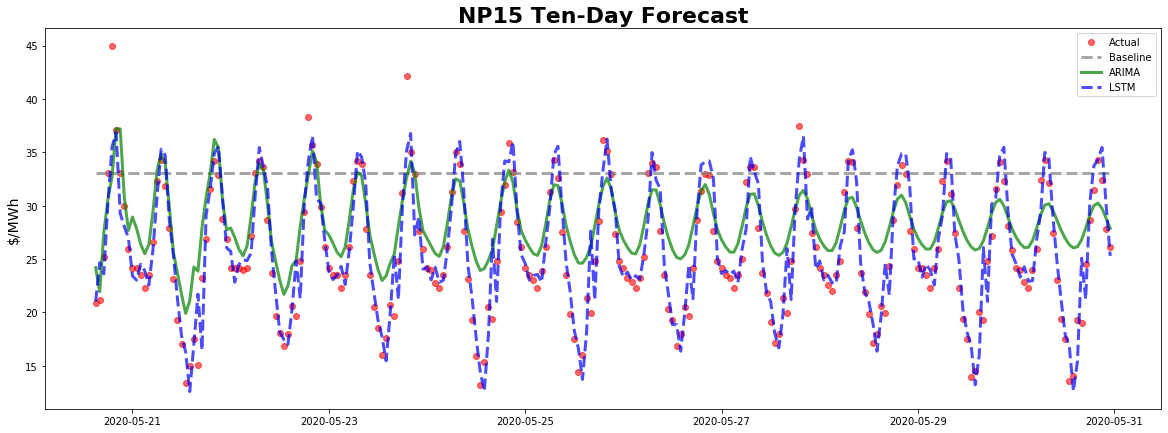

In [93]:
plot_actual_arima_baselie_lstm(caiso.index[train_split_idx:], y1_valid, np_uni_arima_pred, base_pred, np_lstm_pred, 'NP15 Ten-Day Forecast')

---
# SP-15

### Univariate ARIMA Model

In [75]:
sp_uni_train, sp_uni_valid, sp_train_rng, sp_valid_rng = arima_uni_var_train_valid_split(sp_lmp_arr, datetime_arr, 11270)
sp_uni_arima = arima_uni_var_fit(sp_uni_train, sp_train_rng, 24, 1, 0)

sp_uni_arima_pred = arima_uni_var_predict(sp_uni_arima, 249)

rmse_sp_uni_arima = round(calc_rmse(sp_uni_arima_pred, sp_uni_valid), 6)
print(f"RMSE: {rmse_sp_uni_arima}")

RMSE: 4.846459


### Baseline Model

In [77]:
sp_base_pred = baseline_fcst(sp_uni_train, len(sp_uni_valid))
rmse_sp_baseline = round(calc_rmse(sp_base_pred, sp_uni_valid), 6)
print(f"RMSE - Baseline: {rmse_sp_baseline}")

RMSE - Baseline: 9.24455


### Univariate LSTM Model

In [78]:
X2_train, X2_valid, y2_train, y2_valid = split_and_windowize(sp_lmp_arr, int(batch_size / 2), train_split)

sp_lstm_uni = compile_and_fit_lstm_uni_var(X2_train, y2_train, batch_size, n_nodes=32, n_epochs=20)

Epoch 1/20
67/67 [==============================] - 8s 119ms/step - loss: 1327.4204
Epoch 2/20
67/67 [==============================] - 8s 115ms/step - loss: 1048.2091
Epoch 3/20
67/67 [==============================] - 8s 115ms/step - loss: 933.3315
Epoch 4/20
67/67 [==============================] - 8s 115ms/step - loss: 847.6437
Epoch 5/20
67/67 [==============================] - 8s 116ms/step - loss: 776.2589
Epoch 6/20
67/67 [==============================] - 8s 115ms/step - loss: 707.3960
Epoch 7/20
67/67 [==============================] - 8s 115ms/step - loss: 648.8766
Epoch 8/20
67/67 [==============================] - 8s 115ms/step - loss: 599.9299
Epoch 9/20
67/67 [==============================] - 8s 115ms/step - loss: 558.2760
Epoch 10/20
67/67 [==============================] - 8s 116ms/step - loss: 522.2498
Epoch 11/20
67/67 [==============================] - 8s 115ms/step - loss: 490.7696
Epoch 12/20
67/67 [==============================] - 8s 116ms/step - loss: 463.3105

In [85]:
sp_lstm_pred = lstm_uni_pred(sp_lstm_uni, X2_valid)
sp_rmse_lstm_uni = round(calc_rmse(y2_valid, sp_lstm_pred), 6)
print(f"RMSE - SP15 LSTM: {sp_rmse_lstm_uni}")

RMSE - SP15 LSTM: 3.571414


### Comparative Plot

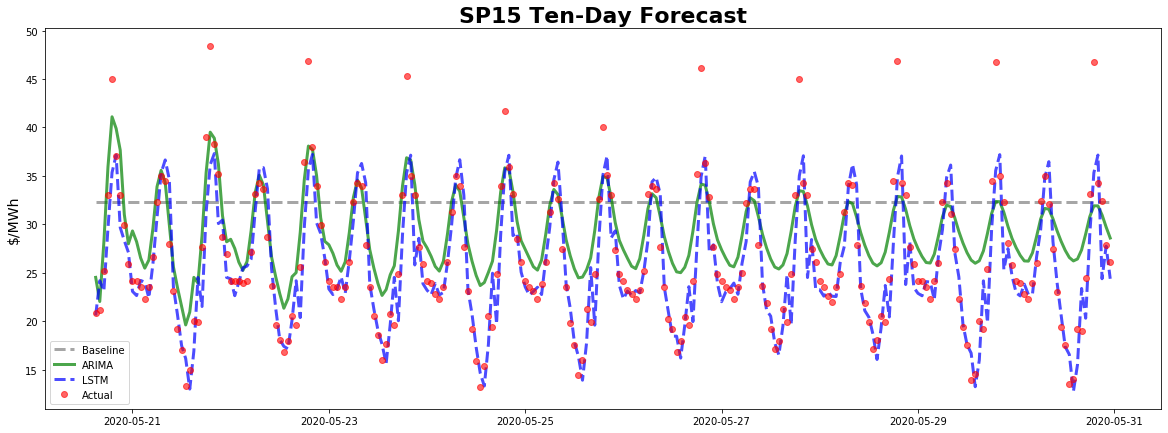

In [86]:
plot_actual_arima_baselie_lstm(caiso.index[train_split_idx:], y2_valid, sp_uni_arima_pred, sp_base_pred, sp_lstm_pred, 'SP15 Ten-Day Forecast')

---
# ZP26

### Univariable ARIMA Model

In [82]:
zp_uni_train, zp_uni_valid, zp_train_rng, zp_valid_rng = arima_uni_var_train_valid_split(zp_lmp_arr, datetime_arr, 11270)
zp_uni_arima = arima_uni_var_fit(zp_uni_train, zp_train_rng, 24, 1, 0)

zp_uni_arima_pred = arima_uni_var_predict(zp_uni_arima, 249)

rmse_zp_uni_arima = round(calc_rmse(zp_uni_arima_pred, zp_uni_valid), 6)
print(f"RMSE: {rmse_zp_uni_arima}")

RMSE: 4.341702


### Basline Model

In [83]:
zp_base_pred = baseline_fcst(zp_uni_train, len(zp_uni_valid))
rmse_zp_baseline = round(calc_rmse(zp_base_pred, zp_uni_valid), 6)
print(f"RMSE - Baseline: {rmse_zp_baseline}")

RMSE - Baseline: 8.715664


### Univariate LSTM

In [84]:
X3_train, X3_valid, y3_train, y3_valid = split_and_windowize(zp_lmp_arr, int(batch_size / 2), train_split)

zp_lstm_uni = compile_and_fit_lstm_uni_var(X3_train, y3_train, batch_size, n_nodes=32, n_epochs=20)

Epoch 1/20
67/67 [==============================] - 8s 119ms/step - loss: 1234.7350
Epoch 2/20
67/67 [==============================] - 8s 114ms/step - loss: 991.5219
Epoch 3/20
67/67 [==============================] - 8s 115ms/step - loss: 885.0872
Epoch 4/20
67/67 [==============================] - 8s 115ms/step - loss: 803.8567
Epoch 5/20
67/67 [==============================] - 8s 115ms/step - loss: 736.4525
Epoch 6/20
67/67 [==============================] - 8s 114ms/step - loss: 672.5298
Epoch 7/20
67/67 [==============================] - 8s 114ms/step - loss: 616.5798
Epoch 8/20
67/67 [==============================] - 8s 115ms/step - loss: 568.2156
Epoch 9/20
67/67 [==============================] - 8s 115ms/step - loss: 527.5847
Epoch 10/20
67/67 [==============================] - 8s 115ms/step - loss: 493.1136
Epoch 11/20
67/67 [==============================] - 8s 115ms/step - loss: 462.7915
Epoch 12/20
67/67 [==============================] - 8s 115ms/step - loss: 435.6078


In [87]:
zp_lstm_pred = lstm_uni_pred(zp_lstm_uni, X3_valid)
zp_rmse_lstm_uni = round(calc_rmse(y3_valid, zp_lstm_pred), 6)
print(f"RMSE - ZP26 LSTM: {zp_rmse_lstm_uni}")

RMSE - ZP26 LSTM: 2.583783


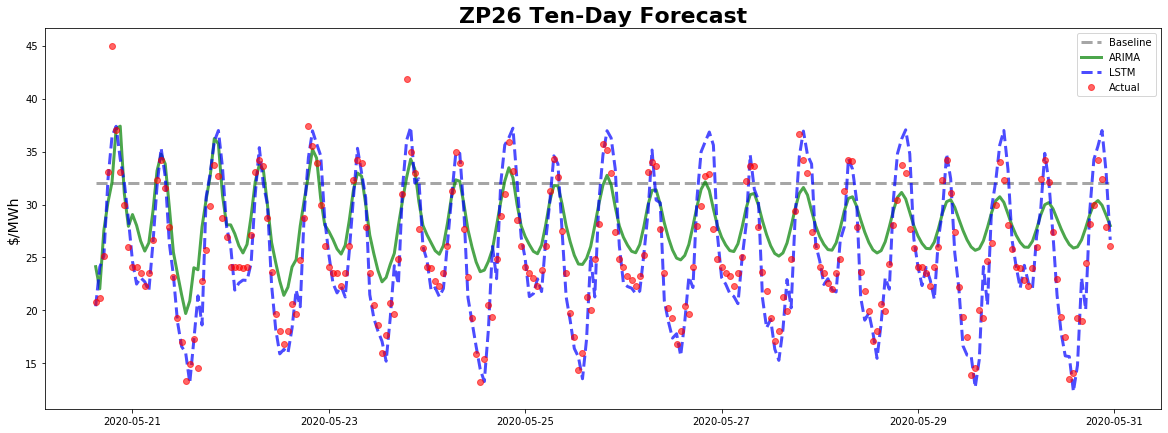

In [88]:
plot_actual_arima_baselie_lstm(caiso.index[train_split_idx:], y3_valid, zp_uni_arima_pred, zp_base_pred, zp_lstm_pred, 'ZP26 Ten-Day Forecast')


## Multivariate LSTM

### VAR - Multivariable

In [159]:
def multivariate_data_windowize_split(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    """"
    Source: https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset.iloc[indices, :])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [160]:
np_multi_lstm_features.index

RangeIndex(start=0, stop=11519, step=1)

In [161]:
np_multi_lstm_features = caiso[['load_MW', '$_MWH_np15', 'HH_$_mill_BTU', 'other', 'solar', 'wind']].copy().reset_index()
np_multi_lstm_features.drop('INTERVAL_START_PT', axis=1, inplace=True)
start_idx = np_multi_lstm_features.index[0]
end_idx = np_multi_lstm_features.index[train_test_date_delim_idx]
# Standardize dataset
np_multi_lstm_mean = np_multi_lstm_features[:train_test_date_delim_idx].mean(axis=0)
np_multi_lstm_std = np_multi_lstm_features[:train_test_date_delim_idx].std(axis=0)
np_multi_lstm_features = (np_multi_lstm_features - np_multi_lstm_mean) / np_multi_lstm_std

X2_train, y2_train = multivariate_data_windowize_split(np_multi_lstm_features, np_multi_lstm_features.iloc[:, 1], 0, train_test_date_delim_idx, 24*7, 
                                                       249, 1, single_step=True)

X2_test, y2_test = multivariate_data_windowize_split(np_multi_lstm_features, np_multi_lstm_features.iloc[:, 1], train_test_date_delim_idx, None, 24*7, 
                                                     249, 1, single_step=True)

ValueError: cannot copy sequence with size 168 to array axis with dimension 6

In [155]:
print ('Single window of past history : {}'.format(X2_train.shape))

Single window of past history : (11102, 168)


In [154]:
n_features = X2_train.shape[2]

IndexError: tuple index out of range

In [156]:


np_lstm_multi = keras.Sequential()
np_lstm_multi.add(keras.layers.LSTM(32, input_shape=X2_train.shape[-2:], return_sequences=True))
np_lstm_multi.add(keras.layers.LSTM(32, return_sequences=True))
np_lstm_multi.add(keras.layers.LSTM(32, return_sequences=False))
# The Dense value is the output sequence.
np_lstm_multi.add(keras.layers.Dense(1, activation='linear'))
np_lstm_multi.compile(optimizer='adam',loss='mse')

In [158]:
X2_train.shape[-2:]

(11102, 168)

In [157]:
np_lstm_multi.fit(X2_train, y2_train, batch_size, epochs=20)

Epoch 1/20


ValueError: in user code:

    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 168]
